In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import io
import sys
import tensorflow as tf
import time
import pathlib
import random
import numpy as np
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
from tensorflow import keras
import tensorflow_hub as hub
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense,Flatten,TextVectorization
from keras import layers,Model,applications,optimizers,losses
from keras.utils import plot_model,image_dataset_from_directory,pad_sequences
from keras.callbacks import TensorBoard
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir
from helper_functions import calculate_results
from keras.callbacks import ModelCheckpoint
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.utils import to_categorical
import string
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from helper_functions import create_tensorboard_callback

In [2]:
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [3]:
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

In [4]:
def get_lines(filename):
  with open(filename, "r") as f:
    return f.readlines()

In [5]:
train_lines = get_lines(data_dir+"train.txt")
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [6]:
filename=data_dir+"train.txt"

In [7]:
abstract_samples = [] 

In [8]:
def preprocess_text_with_line_numbers(filename):
  input_lines = get_lines(filename)
  for line in input_lines:
      if line.startswith("###"): 
        abstract_id = line
        abstract_lines = "" 
      elif line.isspace(): 
        abstract_line_split = abstract_lines.splitlines() 
        for abstract_line_number, abstract_line in enumerate(abstract_line_split):
          line_data = {} # create empty dict to store data from line
          target_text_split = abstract_line.split("\t") # split target label from text
          line_data["target"] = target_text_split[0] # get target label
          line_data["text"] = target_text_split[1].lower() # get target text and lower it
          line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
          line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
          abstract_samples.append(line_data) # add line data to abstract samples list
      else: 
        abstract_lines += line
  return abstract_samples

In [9]:
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") # dev is another name for validation set
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [10]:
train_df

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
...,...,...,...,...
240382,RESULTS,there was a statistically significant between-...,13,17
240383,RESULTS,there were no statistically significant betwee...,14,17
240384,RESULTS,there was no significant association between s...,15,17
240385,RESULTS,no adverse effects were reported .,16,17


In [11]:
train_df['target'].value_counts()

METHODS        79214
RESULTS        77507
CONCLUSIONS    36321
BACKGROUND     28797
OBJECTIVE      18548
Name: target, dtype: int64

<AxesSubplot:ylabel='Frequency'>

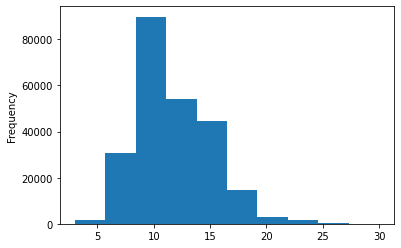

In [12]:
train_df['total_lines'].plot.hist()

In [13]:
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences),len(val_sentences),len(test_sentences)

(240387, 240387, 240387)

In [14]:
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.]])

In [15]:
label_encoder = LabelEncoder()
label_encoder.fit_transform(train_df["target"].to_numpy())

array([3, 2, 2, ..., 4, 4, 1])

In [16]:
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())
# Check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 4, 1])

In [17]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

In [18]:
train_sentences[:4],label_encoder.classes_[train_labels_encoded[:4]]

(['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'pain was assessed using the visual analog pain scale ( @-@ mm ) .'],
 array(['OBJECTIVE', 'METHODS', 'METHODS', 'METHODS'], dtype=object))

In [19]:
model_0 = Pipeline([
    ("tf-idf",TfidfVectorizer()),
    ("clf", MultinomialNB())
])
model_0.fit(X=train_sentences, 
            y=train_labels_encoded);

In [20]:
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7525656545487068

In [21]:
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([1, 2, 4, ..., 4, 4, 1])

In [22]:
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 75.25656545487068,
 'precision': 0.7547364435220734,
 'recall': 0.7525656545487068,
 'f1': 0.7364466619916601}

In [23]:
train_samples

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [24]:
# How long is each sentence on average?
sent_lens=[len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
len(sent_lens),np.mean(sent_lens)

(240387, 26.32881561814907)

In [25]:
sent_lens[:10]

[49, 27, 15, 14, 35, 29, 30, 55, 36, 8]

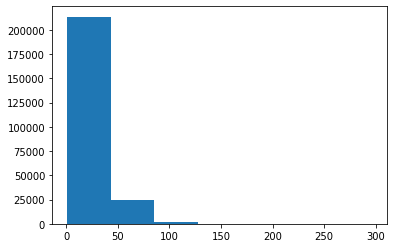

In [26]:
plt.hist(sent_lens, bins=7);

In [27]:
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [28]:
#stated in paper abt unique vocab is 68000
max_tokens = 68000

In [29]:
text_vectorizer = TextVectorization(max_tokens=max_tokens,output_sequence_length=output_seq_len)
text_vectorizer.adapt(train_sentences)

In [30]:
text_vectorizer("how do you do you")

<tf.Tensor: shape=(55,), dtype=int64, numpy=
array([  905,  1042, 11224,  1042, 11224,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0])>

In [31]:
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text:\n{text_vectorizer([target_sentence])}")

Text:
glycerol-preserved bone allografts exhibit fusion results and subsidence values similar to those of their freeze-dried counterparts , potentially more favorable biomechanical properties , and significantly shorter preparation times .

Length of text: 29

Vectorized text:
[[26843   415 12798  5771  2441   117     3 15263   336   152     6   126
      4   123 12228  6609  1186    69  1553  4840  1586     3    39   727
   1417   365     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [32]:
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
len(text_vectorizer.get_vocabulary())

68000

In [33]:
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None}

In [34]:
rct_20k_text_vocab[:10]

['', '[UNK]', 'the', 'and', 'of', 'in', 'to', 'with', 'a', 'were']

In [35]:
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab),output_dim=128,name="token_embedding")
print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
glycerol-preserved bone allografts exhibit fusion results and subsidence values similar to those of their freeze-dried counterparts , potentially more favorable biomechanical properties , and significantly shorter preparation times .

Sentence after vectorization (before embedding):
[[26843   415 12798  5771  2441   117     3 15263   336   152     6   126
      4   123 12228  6609  1186    69  1553  4840  1586     3    39   727
   1417   365     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding:
[[[-0.00067093 -0.02851229  0.03401878 ... -0.01320054  0.00333146
    0.04127148]
  [ 0.04545219 -0.00429454 -0.03296645 ... -0.01385138 -0.02210616
   -0.01048982]
  [-0.0325969  -0.02599994 -0.01732054 ... -0.00432478 -0.03103838
   -0.02750697]
  ...
  [ 0.00998725 -0.01784315  0.01923089 ...  0.04722064  0.001

In [36]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

In [37]:
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.]])

In [38]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))
train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [39]:
# Take the TensorSliceDataset's and turn them into prefetched batches
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [40]:
inputs= layers.Input(shape=(1,),dtype=tf.string)
x=text_vectorizer(inputs)
embeddings=token_embed(x)
x=layers.Conv1D(64,5,padding='same',activation='relu')(embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = Dense(len(label_encoder.classes_),activation="softmax")(x)
model_1 = Model(inputs,outputs)
model_1.compile(loss="categorical_crossentropy", # if your labels are integer form (not one hot) use sparse_categorical_crossentropy
                optimizer=optimizers.Adam(),
                metrics=["accuracy"])

In [41]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8704000   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

In [42]:
model_1.fit(train_dataset,epochs=3,steps_per_epoch=int(0.1 * len(train_dataset)),validation_steps=int(0.1 * len(train_dataset)))

Epoch 1/3
751/751 [==============================] - 10s 8ms/step - loss: 0.8546 - accuracy: 0.6673
Epoch 2/3
751/751 [==============================] - 5s 7ms/step - loss: 0.6303 - accuracy: 0.7665
Epoch 3/3
751/751 [==============================] - 5s 7ms/step - loss: 0.5977 - accuracy: 0.7839


In [43]:
model_1.evaluate(valid_dataset)

7513/7513 [==============================] - 43s 6ms/step - loss: 0.5482 - accuracy: 0.8034


[0.5482458472251892, 0.8033878803253174]

In [44]:
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs

7513/7513 [==============================] - 16s 2ms/step


array([[1.1527557e-01, 3.9512407e-02, 2.5355976e-04, 8.4495306e-01,
        5.4572552e-06],
       [9.2841437e-05, 2.4242673e-04, 9.7899026e-01, 5.7314366e-05,
        2.0617124e-02],
       [9.5257843e-03, 2.7070930e-02, 6.8743235e-01, 3.6231359e-03,
        2.7234784e-01],
       ...,
       [3.9854660e-03, 3.8110301e-02, 3.6951933e-02, 1.2833681e-03,
        9.1966897e-01],
       [4.5131710e-03, 1.9357519e-02, 6.6232137e-02, 1.3430754e-03,
        9.0855408e-01],
       [9.7327232e-03, 5.6682080e-01, 9.9178761e-02, 5.2792002e-03,
        3.1898859e-01]], dtype=float32)

In [45]:
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(240387,), dtype=int64, numpy=array([3, 2, 2, ..., 4, 4, 1])>

In [46]:
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results                                    

{'accuracy': 80.33878703923257,
 'precision': 0.8035941446601081,
 'recall': 0.8033878703923257,
 'f1': 0.799217754836898}

In [47]:
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [48]:
random_training_sentence = random.choice(train_sentences)
print(f"Random training sentence:\n{random_training_sentence}\n")
use_embedded_sentence = tf_hub_embedding_layer([random_training_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]} (truncated output)...\n")
print(f"Length of sentence embedding:\n{use_embedded_sentence.shape}")

Random training sentence:
significant reduction in plasma cholesterol , triglyceride , high-density lipoprotein cholesterol , and c-reactive protein were found in both exercise groups , whereas low-density lipoprotein cholesterol , cortisol , and interleukin-@ concentrations decreased only in the bwm group .

Sentence after embedding:
[-0.00775272 -0.02392543 -0.05411442 -0.02233707 -0.01037179  0.02898209
  0.04284377 -0.05194772 -0.0354954  -0.00180048  0.07201859 -0.04079261
 -0.01990353 -0.0146194  -0.07038675 -0.05042912 -0.0720571  -0.00565657
  0.05452041  0.0290099  -0.06305298  0.0231829   0.00284219 -0.03752173
  0.0397733  -0.05281362  0.04569653  0.06571998 -0.01287089 -0.05593242] (truncated output)...

Length of sentence embedding:
(1, 512)


In [106]:
inputs= layers.Input(shape=[],dtype=tf.string)
x=tf_hub_embedding_layer(inputs)
x=Dense(128,activation='relu')(x)
outputs=Dense(num_classes,activation='softmax')(x)
model_2=Model(inputs,outputs)
model_2.compile(loss="categorical_crossentropy",optimizer=optimizers.Adam(),metrics='accuracy')
model_2.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_11 (Dense)            (None, 128)               65664     
                                                                 
 dense_12 (Dense)            (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [107]:
valid_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [108]:
# Fit feature extractor model for 3 epochs
model_2.fit(train_dataset,
            steps_per_epoch=int(0.1 * len(train_dataset)),
            epochs=3,
            validation_data=valid_dataset,
            validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/3
751/751 [==============================] - 24s 30ms/step - loss: 0.8829 - accuracy: 0.6619 - val_loss: 0.7624 - val_accuracy: 0.7080
Epoch 2/3
751/751 [==============================] - 22s 29ms/step - loss: 0.7554 - accuracy: 0.7100 - val_loss: 0.7359 - val_accuracy: 0.7185
Epoch 3/3
751/751 [==============================] - 22s 29ms/step - loss: 0.7280 - accuracy: 0.7184 - val_loss: 0.7168 - val_accuracy: 0.7272


In [52]:
model_2.evaluate(valid_dataset)

7513/7513 [==============================] - 109s 15ms/step - loss: nan - accuracy: 0.1198


[nan, 0.1197943314909935]

In [53]:
# Make predictions with feature extraction model
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)

len(model_2_preds),len(val_labels_encoded)

7513/7513 [==============================] - 97s 13ms/step


(240387, 240387)

In [54]:
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

/home/butt_sahab/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 11.979433164023012,
 'precision': 0.01435068189312944,
 'recall': 0.11979433164023012,
 'f1': 0.025630924336095064}

In [55]:
def split_chars(text):
  return " ".join(list(text))
split_chars(random_training_sentence)

's i g n i f i c a n t   r e d u c t i o n   i n   p l a s m a   c h o l e s t e r o l   ,   t r i g l y c e r i d e   ,   h i g h - d e n s i t y   l i p o p r o t e i n   c h o l e s t e r o l   ,   a n d   c - r e a c t i v e   p r o t e i n   w e r e   f o u n d   i n   b o t h   e x e r c i s e   g r o u p s   ,   w h e r e a s   l o w - d e n s i t y   l i p o p r o t e i n   c h o l e s t e r o l   ,   c o r t i s o l   ,   a n d   i n t e r l e u k i n - @   c o n c e n t r a t i o n s   d e c r e a s e d   o n l y   i n   t h e   b w m   g r o u p   .'

In [56]:
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

In [57]:
char_lens = [len(x) for x in train_sentences]
mean_char_len = np.mean(char_lens)
char_lens[:10],np.mean(char_lens)

([281, 137, 111, 65, 209, 147, 161, 164, 180, 51], 149.23063227212785)

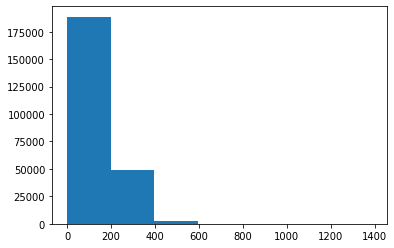

In [58]:
plt.hist(char_lens, bins=7);

In [59]:
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [60]:
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet,len(alphabet)

('abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~', 68)

In [61]:
train_chars[:1]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .']

In [62]:
NUM_CHAR_TOKENS = len(alphabet) + 2 # num characters in alphabet + space + OOV token
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,output_sequence_length=output_seq_char_len,name="char_vectorizer")
char_vectorizer.adapt(train_chars)

In [63]:
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [64]:
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
a t   d a y   @   ,   t h e   a c p r   w a s   @   %   i n   t h e   a s a q   g r o u p   v e r s u s   @   %   f o r   b o t h   a l   a n d   d h a p q   g r o u p s   ,   (   p   =   @   )   .

Length of chars: 71

Vectorized chars:
[[ 5  3 10  5 19  3 13  2  5 11 14  8 20  5  9  4  6  3 13  2  5  9  5 26
  18  8  7 16 14 21  2  8  9 16  9 17  7  8 22  7  3 13  5 12  5  6 10 10
  13  5 14 26 18  8  7 16 14  9 14  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  

In [65]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim=NUM_CHAR_TOKENS, # number of different characters
                              output_dim=25, # embedding dimension of each character (same as Figure 1 in https://arxiv.org/pdf/1612.05251.pdf)
                              mask_zero=False, # don't use masks (this messes up model_5 if set to True)
                              name="char_embed")

# Test out character embedding layer
print(f"Charified text (before vectorization and embedding):\n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text (before vectorization and embedding):
a t   d a y   @   ,   t h e   a c p r   w a s   @   %   i n   t h e   a s a q   g r o u p   v e r s u s   @   %   f o r   b o t h   a l   a n d   d h a p q   g r o u p s   ,   (   p   =   @   )   .

Embedded chars (after vectorization and embedding):
[[[-0.01310264  0.00517013 -0.01468712 ...  0.00618917 -0.00673505
    0.00777389]
  [ 0.01246921  0.00022485 -0.01361018 ...  0.00846629 -0.00047948
    0.04243955]
  [ 0.04139501 -0.0134856  -0.01905259 ...  0.02339499 -0.02998035
   -0.04761591]
  ...
  [-0.02276758  0.04445971 -0.01316111 ... -0.03734318 -0.03103284
   -0.0389853 ]
  [-0.02276758  0.04445971 -0.01316111 ... -0.03734318 -0.03103284
   -0.0389853 ]
  [-0.02276758  0.04445971 -0.01316111 ... -0.03734318 -0.03103284
   -0.0389853 ]]]

Character embedding shape: (1, 290, 25)


In [66]:
inputs = layers.Input(shape=(1,),dtype=tf.string)
c=char_vectorizer(inputs)
e=char_embed(c)
x=layers.Conv1D(64,5,padding="same", activation="relu")(e)
x = layers.GlobalMaxPool1D()(x)
outputs=Dense(num_classes, activation="softmax")(x)
model_3=Model(inputs,outputs)
model_3.compile(loss="categorical_crossentropy",optimizer=optimizers.Adam(),metrics="accuracy")
model_3.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           1750      
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_3 (Dense)             (None, 5)                 325 

In [67]:
train_labels_one_hot[0],train_chars[0]

(array([0., 0., 0., 1., 0.]),
 't o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .')

In [68]:
# Create char datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
train_char_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [69]:
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1 * len(val_char_dataset)))

Epoch 1/3
751/751 [==============================] - 8s 10ms/step - loss: 1.2103 - accuracy: 0.5082 - val_loss: 1.0119 - val_accuracy: 0.5939
Epoch 2/3
751/751 [==============================] - 8s 10ms/step - loss: 0.9645 - accuracy: 0.6146 - val_loss: 0.9092 - val_accuracy: 0.6473
Epoch 3/3
751/751 [==============================] - 8s 10ms/step - loss: 0.8934 - accuracy: 0.6511 - val_loss: 0.8701 - val_accuracy: 0.6605


In [70]:
model_3.evaluate(val_char_dataset)

7513/7513 [==============================] - 41s 5ms/step - loss: 0.8691 - accuracy: 0.6607


[0.869056761264801, 0.6606721878051758]

In [110]:
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_results = calculate_results(y_true=val_labels_encoded,
                                        y_pred=model_3_preds)

7513/7513 [==============================] - 24s 3ms/step


In [72]:
model_3_results

{'accuracy': 66.0672166132112,
 'precision': 0.6636520429717223,
 'recall': 0.660672166132112,
 'f1': 0.6507798230658784}

In [73]:
token_inputs = layers.Input(shape=[],dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output=Dense(128,activation='relu')(token_embeddings)
token_model = Model(token_inputs,token_output)

char_inputs = layers.Input(shape=(1,),dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings) 
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,char_model.output])

combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation="relu")(combined_dropout) 
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   [

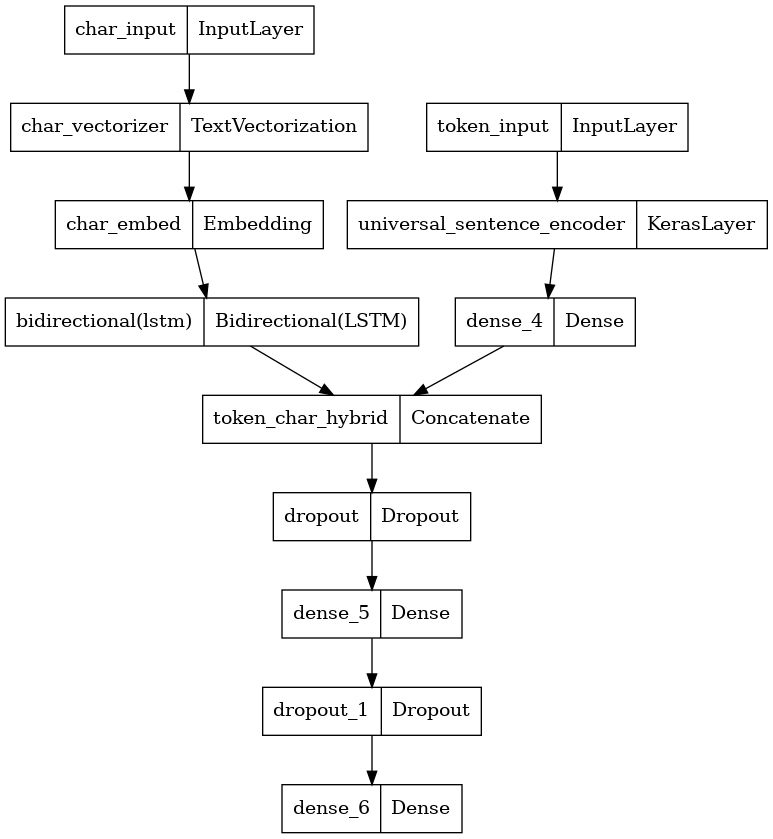

In [74]:
plot_model(model_4)

In [75]:
model_4.compile(loss=losses.CategoricalCrossentropy(),optimizer=optimizers.Adam(),metrics='accuracy')

In [76]:
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences,train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels))
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) 
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [77]:
train_char_token_dataset, val_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [78]:
model_4_history = model_4.fit(train_char_token_dataset, 
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/3
751/751 [==============================] - 45s 57ms/step - loss: 0.9323 - accuracy: 0.6338 - val_loss: 0.7313 - val_accuracy: 0.7224
Epoch 2/3
751/751 [==============================] - 42s 56ms/step - loss: 0.7720 - accuracy: 0.7038 - val_loss: 0.6886 - val_accuracy: 0.7378
Epoch 3/3
751/751 [==============================] - 42s 55ms/step - loss: 0.7454 - accuracy: 0.7184 - val_loss: 0.6733 - val_accuracy: 0.7453


In [79]:
model_4.evaluate(val_char_token_dataset)

7513/7513 [==============================] - 175s 23ms/step - loss: 0.6732 - accuracy: 0.7444


[0.6732461452484131, 0.7443913221359253]

In [80]:
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

7513/7513 [==============================] - 157s 21ms/step


{'accuracy': 74.43913356379504,
 'precision': 0.7441169512135887,
 'recall': 0.7443913356379505,
 'f1': 0.7410435394871571}

<AxesSubplot:ylabel='Frequency'>

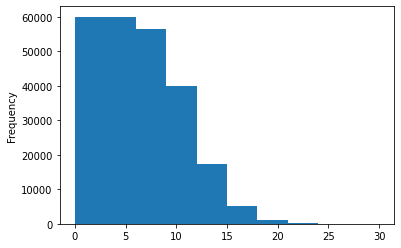

In [81]:
train_df['line_number'].plot.hist()

In [82]:
np.percentile(train_df['line_number'],98.5)

16.0

In [83]:
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=16)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=16)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=16)

In [84]:
train_line_numbers_one_hot.shape, train_line_numbers_one_hot[:20]

(TensorShape([240387, 16]),
 <tf.Tensor: shape=(20, 16), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 

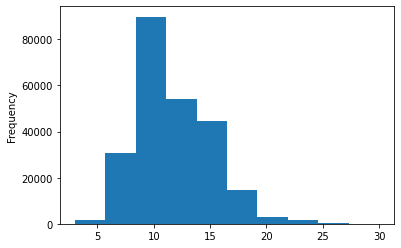

In [85]:
train_df['total_lines'].plot.hist();

In [86]:
np.percentile(train_df.total_lines, 99) 

21.0

In [87]:
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)
train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([240387, 20]),
 <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0

In [88]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)
# 3. Line_num inputs
line_number_input = layers.Input(shape=(16,), dtype=tf.int32,  name="line_number_input")
line_num_output=Dense(32,activation='relu')(line_number_input)
line_num_model=Model(line_number_input,line_num_output)

# 3. Total_Line inputs
total_line_input = layers.Input(shape=(20,), dtype=tf.int32, name="total_lines_input")
total_line_output=Dense(32,activation='relu')(total_line_input)
total_line_model=Model(total_line_input,total_line_output)

token_char_concat = layers.Concatenate(name="token_char_hybrid_embedding")(([token_model.output,char_model.output]))

z = layers.Dense(256, activation="softmax")(token_char_concat)
z = layers.Dropout(0.5)(z)

z=layers.Concatenate(name="token_char_positional_embedding")([total_line_model.output,line_num_model.output,z])

output_layer = layers.Dense(5, activation="softmax", name="output_layer")(z)

model_5 = tf.keras.Model(inputs=[line_num_model.input,
                                 total_line_model.input,
                                 token_model.input, 
                                 char_model.input],
                         outputs=output_layer)
model_5.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inputs[0][0]']     

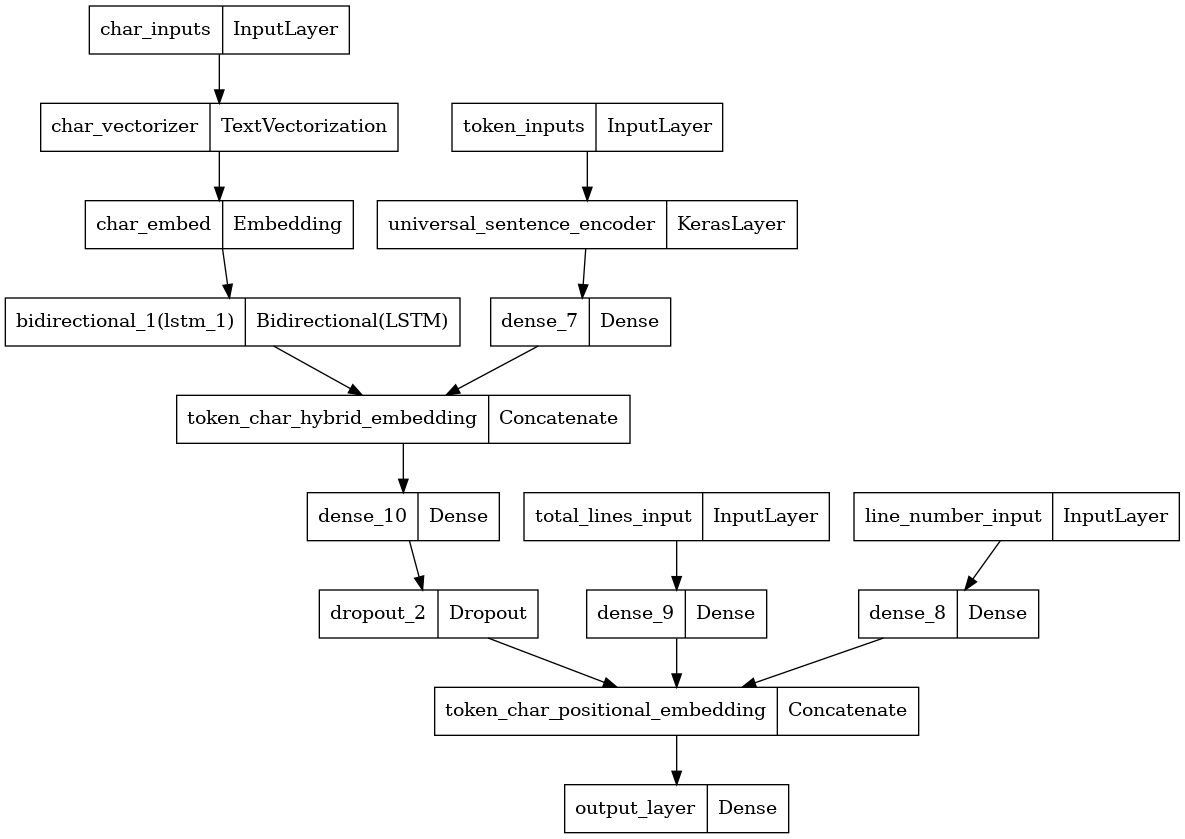

In [89]:
plot_model(model_5)

In [90]:
for layer in model_5.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f5f3dac6f10> True
<keras.engine.input_layer.InputLayer object at 0x7f5f8f6cf7c0> True
<keras.layers.preprocessing.text_vectorization.TextVectorization object at 0x7f5f34153100> True
<tensorflow_hub.keras_layer.KerasLayer object at 0x7f5f34157850> False
<keras.layers.core.embedding.Embedding object at 0x7f5de97cc400> True
<keras.layers.core.dense.Dense object at 0x7f5f8f98f3d0> True
<keras.layers.rnn.bidirectional.Bidirectional object at 0x7f5e881dba30> True
<keras.layers.merging.concatenate.Concatenate object at 0x7f5de96a0520> True
<keras.engine.input_layer.InputLayer object at 0x7f5de968e370> True
<keras.engine.input_layer.InputLayer object at 0x7f5de9718580> True
<keras.layers.core.dense.Dense object at 0x7f5de96a0b50> True
<keras.layers.core.dense.Dense object at 0x7f5f3dc93520> True
<keras.layers.core.dense.Dense object at 0x7f5f340a1df0> True
<keras.layers.regularization.dropout.Dropout object at 0x7f5de972cf10> True
<keras.layers

In [91]:
model_5.compile(loss=losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer=optimizers.Adam(),
                metrics=["accuracy"])

In [92]:
# Create training and validation datasets (all four kinds of inputs)
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, # line numbers
                                                                train_total_lines_one_hot, # total lines
                                                                train_sentences, # train tokens
                                                                train_chars)) # train chars
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # train labels
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) # combine data and labels
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Check input shapes
train_pos_char_token_dataset, val_pos_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None, 16), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None, 16), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [93]:
history_model_5 = model_5.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                              epochs=5,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.1 * len(val_pos_char_token_dataset)))

Epoch 1/5
751/751 [==============================] - 46s 59ms/step - loss: 1.2256 - accuracy: 0.6121 - val_loss: 1.0688 - val_accuracy: 0.7286
Epoch 2/5
751/751 [==============================] - 43s 57ms/step - loss: 1.0662 - accuracy: 0.7328 - val_loss: 1.0341 - val_accuracy: 0.7622
Epoch 3/5
751/751 [==============================] - 43s 57ms/step - loss: 1.0439 - accuracy: 0.7540 - val_loss: 1.0122 - val_accuracy: 0.7802
Epoch 4/5
751/751 [==============================] - 43s 57ms/step - loss: 1.0286 - accuracy: 0.7674 - val_loss: 0.9919 - val_accuracy: 0.7990
Epoch 5/5
751/751 [==============================] - 43s 57ms/step - loss: 1.0154 - accuracy: 0.7800 - val_loss: 0.9833 - val_accuracy: 0.8050


In [94]:
model_5_pred_probs = model_5.predict(val_pos_char_token_dataset, verbose=1)
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

7513/7513 [==============================] - 160s 21ms/step


{'accuracy': 80.90412543107573,
 'precision': 0.8046878159702374,
 'recall': 0.8090412543107572,
 'f1': 0.8049174861726234}

In [112]:
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "custom_token_embed_conv1d": model_1_results,
                                  "pretrained_token_embed": model_2_results,
                                  "custom_char_embed_conv1d": model_3_results,
                                  "hybrid_char_token_embed": model_4_results,
                                  "tribrid_pos_char_token_embed": model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,75.256565,0.754736,0.752566,0.736447
custom_token_embed_conv1d,80.338787,0.803594,0.803388,0.799218
pretrained_token_embed,11.979433,0.014351,0.119794,0.025631
custom_char_embed_conv1d,55.907349,0.601965,0.559073,0.549133
hybrid_char_token_embed,74.439134,0.744117,0.744391,0.741044
tribrid_pos_char_token_embed,80.904125,0.804688,0.809041,0.804917


In [98]:
all_model_results["accuracy"] = all_model_results["accuracy"]/100

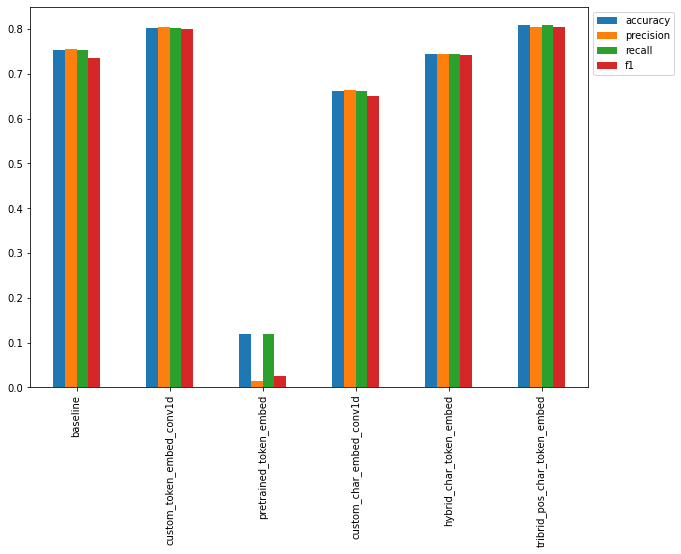

In [111]:
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

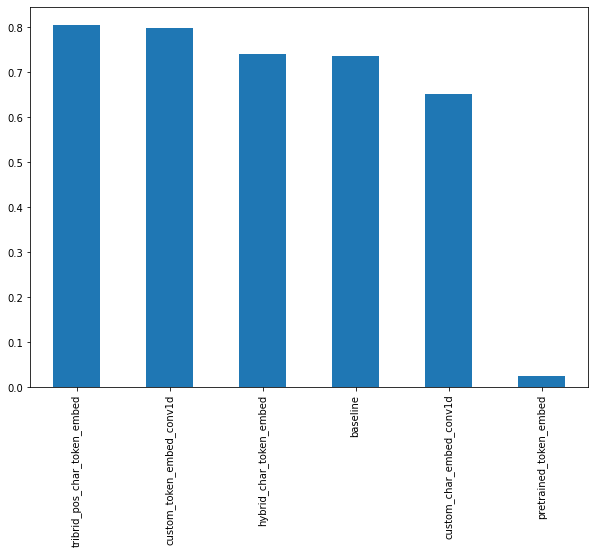

In [109]:
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));